# Imports and definitions

In [1]:
from XRDXRFutils.notebook_utils import *

### Base path ###
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
spot_name = 'p3verde100s'
path_input = path_shared + 'dataXRDXRF/CappellaBrancacci/CappellaBrancacciFirenzeXRD/Puntuali/'
path_spot = path_input + spot_name + '/'

file_xrd         = path_spot + 'Frame0001.dat'   # XRD scan
file_calibration = path_input + 'calibration.ini'
file_xrf = path_spot + spot_name + '.spe'    # XRF scan

list_path_database = [path_shared + 'Database16_42/']   # tabulated phases

### Output ###
subfolder_output = 'SpotResults/' + spot_name + '/'
path_figures = subfolder_output + 'figures/'            # figures generated by the script
path_database_exp = subfolder_output + 'databaseEXP/'   # experimental phases
path_calibrations = subfolder_output + 'calibrations/'  # calibrated XRD spectra
path_peaks = subfolder_output + 'peaks/'                # peaks automatically found in experimental XRD pattern

paths_to_create_delete = [subfolder_output, path_figures, path_database_exp, path_calibrations, path_peaks]

### Fit ###
sigma = 0.20             # sigma used in the peaks of synthetic diffraction patterns
min_theta = 17
max_theta = 42
min_intensity = 0.05     # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None     # selects the first n most intense peaks (if None, leaves all the peaks)
distance_merge = sigma   # Distance under which peaks are merged in each phase. Put None to avoid merging.

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False
if do_you_want_to_delete:
    for path_sel in paths_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in paths_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read phase database

In [4]:
print('Reading phases from: ' + ', '.join(["'" + path + "'" for path in list_path_database]))
database = DatabaseXRD()
for path_database in list_path_database:
    database.read_cifs(path_database)
print(f'Total number of phases: {len(database)}')

Reading phases from: '../../shared/Database16_42/'
Total number of phases: 436


# Read and process XRD data

Loading '../../shared/dataXRDXRF/CappellaBrancacci/CappellaBrancacciFirenzeXRD/Puntuali/p3verde100s/Frame0001.dat'
Data length: 1280
Initial calibration:
a = -71.8, s = 2253.7, beta = 16.997
Theta range [15.17321393 45.17384068]


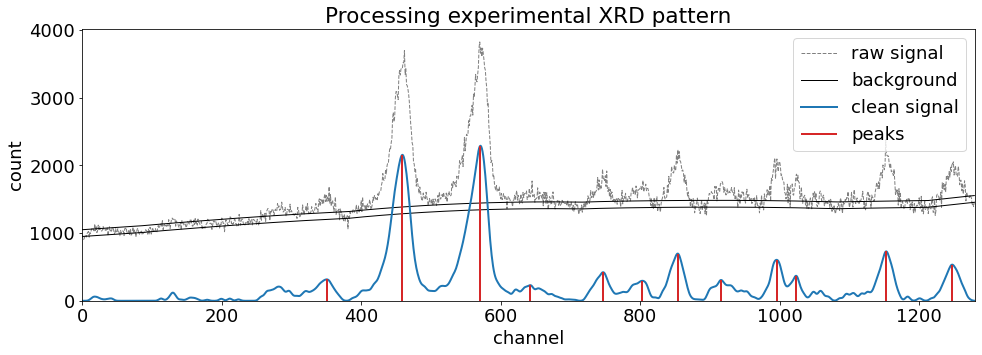

In [5]:
rcParams['font.size'] = 18

### Parameters for smoothing ###
window_snip = 60        # width of the window used for determining the background (default 32)
offset_background = 100   # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 3          # degree of the final smooth applied to the XRD pattern (default 0)

### Parameters for searching peaks ###
width_peak = 5   # Minimum width of the peaks, in channels (default 10)
height_peak = 0.13  # Minimum height of the peaks, between 0 and 1, compared against a logarithmic function of the XRD pattern

###

print(f'Loading \'{file_xrd}\'')
spectrum_xrd = (
    FastSpectraXRD()
    .from_file(file_xrd)
    .calibrate_from_file(file_calibration)
    .remove_background(window_snip = window_snip, offset_background = offset_background)
    .smooth_channels(std_kernel = std_smooth)
)
print(f'Data length: {spectrum_xrd.counts.shape[0]}')
print('Initial calibration:')
print(f'a = {spectrum_xrd.opt[0]:.1f}, s = {spectrum_xrd.opt[1]:.1f}, beta = {spectrum_xrd.opt[2]:.3f}')
print(f'Theta range {spectrum_xrd.theta_range()}')

signal_for_peaks = log(spectrum_xrd.intensity + 1)
signal_for_peaks /= signal_for_peaks.max()
peaks_position = find_peaks(signal_for_peaks, width = width_peak, height = height_peak)[0]
peaks_intensity = spectrum_xrd.intensity[peaks_position]
arr_to_write = concatenate(
    (spectrum_xrd.fce_calibration(peaks_position, *spectrum_xrd.opt)[:, newaxis],
     peaks_intensity[:, newaxis]),
    axis = 1
)
savetxt(f'{path_peaks}xrd peaks with initial calibration.dat', arr_to_write, '%.3f %.3f')

arr_to_write = concatenate((spectrum_xrd.theta[:, newaxis], spectrum_xrd.counts[:, newaxis]), axis = 1)
savetxt(f'{path_calibrations}xrd raw with initial calibration.dat', arr_to_write, '%.3f %i')

arr_to_write = concatenate((spectrum_xrd.theta[:, newaxis], spectrum_xrd.counts_smoothed[:, newaxis]), axis = 1)
savetxt(f'{path_calibrations}xrd smoothed and no-bg with initial calibration.dat', arr_to_write, '%.3f %i')

fig, ax = subplots(figsize = (16, 5))
ax.plot(spectrum_xrd.counts, c = 'grey', ls = '--', lw = 1, label = 'raw signal')
ax.plot(spectrum_xrd.background, c = 'black', ls = '-', lw = 1, label = 'background')
ax.plot(spectrum_xrd.background + spectrum_xrd.offset_background, c = 'black', ls = '-', lw = 1)
ax.plot(spectrum_xrd.counts_smoothed, lw = 2, label = 'clean signal')
ax.vlines(peaks_position, 0, spectrum_xrd.counts_smoothed[peaks_position], color = 'tab:red', lw = 2, label = 'peaks')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(0, len(spectrum_xrd.counts))
ax.set_ylim(0, None)
ax.set_xlabel('channel')
ax.set_ylabel('count')
ax.set_title('Processing experimental XRD pattern')
show()

# Read XRF spectrum

In [6]:
#### inserire calibrazione energia (keV)

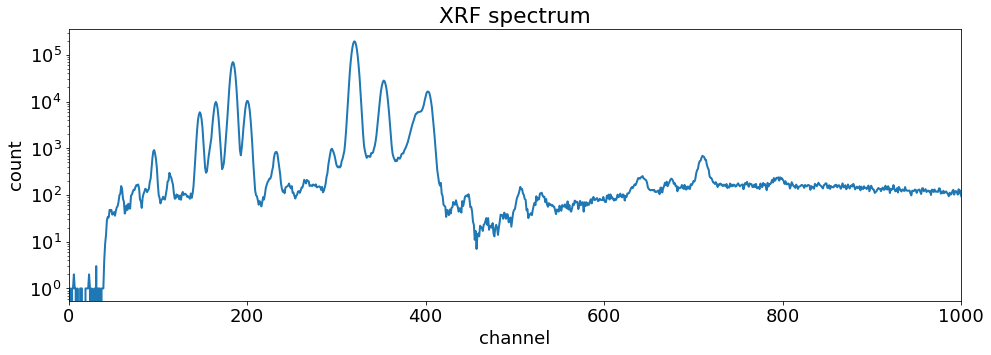

In [7]:
#limits_channel = [0, None]   # default limits
limits_channel = [0, 1000]   # custom limits

log_y_scale = True

spectrum_xrf = SpectraXRF().from_spe(file_xrf)
fig, ax = subplots(figsize = (16, 5))
ax.plot(spectrum_xrf.counts, lw = 2, label = 'raw signal')
if log_y_scale:
    ax.set_yscale('log')
ax.set_xlim(*limits_channel)
ax.set_xlabel('channel')
ax.set_ylabel('count')
ax.set_title('XRF spectrum')
show()

# Choose elements

### View phases of chosen elements
- `elements_chosen`: Elements that need to be in the selected phases.
- `elements_excluded`: Elements that must not be in the selected phases.

In [8]:
elements_chosen = ['Fe']
elements_excluded = []

df_phases = DataFrame(columns = ['Name in database', 'Chemical formula', 'N. of samples'])
for phase_name, phase_set in sorted(database.items()):
    p = phase_set[0]
    if '_chemical_formula_sum' in p:
        
        # Change 'all' (the first) into 'any' if you want to select phases that have at least one of elements_chosen
        
        if (all(is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_chosen)
            and all(not is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_excluded)):
            df_phases.loc[len(df_phases)] = [phase_name, p['_chemical_formula_sum'], len(phase_set)]
elements_excluded = []
df_phases

,Name in database,Chemical formula,N. of samples
0,Akaganeite,Cl0.675 Fe4 O8,2
1,BurntUmberReddish,Fe Mn O Al H,1
2,Burnt_Sienna_Italian,Fe Mn O Al H,2
3,Burnt_Sienna_Italian_2,Fe Mn O Al H,1
4,Burnt_Umber_reddish,Fe Mn O Al H,1
5,Cromossido di ematite,Mg Al Co Cr Fe Cu,1
6,Erythrite,As4 Co4.02 Fe1.48 H32 Ni0.50 O32,1
7,Fe2 O3,Fe2 O3,10
8,Fe2MnO4,Fe2 Mn O4,1
9,FrenchOchreSoforouge,Fe2 O3,1


# Check a phase vs XRD pattern
Plots: fit result, measure of the presence and selected peaks.

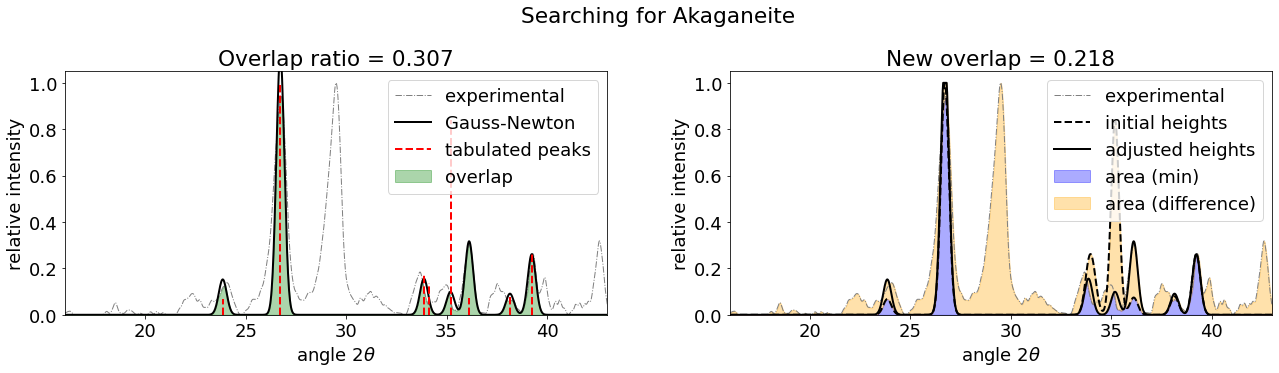

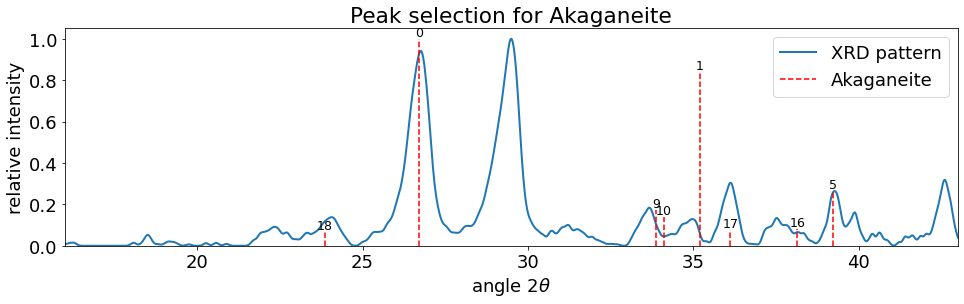

In [14]:
rcParams['font.size'] = 18

### Fit options ###

# Phase that will be checked against the experimental XRD pattern
phase_check = database['Akaganeite'][1]   # V Fe2O3, 1

# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted by fitting phase_calibration on the experimental XRD pattern.
adjust_calibration = True
#phase_calibration = database['Akaganeite'][0]
phase_calibration = phase_check

###

gn = GaussNewton(phase_check, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)

if adjust_calibration:
    gn_calibration = GaussNewton(phase_calibration, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
    gn_calibration.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
    gn.opt = gn_calibration.opt

gn.fit_cycle(gamma = True, steps = 32)

z0 = clip(gn.z0(), None, 1) # to avoid anomalously high peaks resulting from overlapping tabulated peaks
z = clip(gn.z(), None, 1)
intensity_corrected = maximum(gn.intensity, 0)
z_stack = stack((z0, z, intensity_corrected))
z_min = z_stack.min(axis = 0)
z_max = z_stack.max(axis = 0)
presence = z_min.sum() / z_max.sum()

### Measures of phase presence ###

fig, axs = subplots(1, 2, figsize = (18, 5))
fig.tight_layout(w_pad = 4)
fig.subplots_adjust(top = 0.8)   # To shift the title

ax = axs[0]
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
gn.plot_phase(lw = 2, alpha = 1, label = 'tabulated peaks')
ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')

ax = axs[1]
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'area (min)')
ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'area (difference)')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title(f'New overlap = {gn.adjustment_ratio():.3f}')

fig.suptitle(f'Searching for {gn.label}')

show()

### Peak selection ###

fig, ax = subplots(figsize = (16, 4))
sca(ax)
ax.plot(gn.theta, gn.intensity, lw = 2, label = 'XRD pattern')
gn.plot_phase(positions = True)
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, None)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'Peak selection for {gn.label}')
show()

### Select peaks

In [15]:
#database['V Fe2O3'][1].select_peaks([0, 1])
database['V Fe2O3'][1].select_peaks()
database['Potassium Iron Sulfate Hydroxide'][0].select_peaks()
None

# Reduce list of phases

### Fit selected phases on experimental XRD pattern

In [16]:
phase_presence_method = 'adjustment_ratio'
phase_presence_correction = False
# ('overlap_area', True)           # vecchio metodo
# ('overlap_area_ratio', False)    # vecchio metodo, altro modo di realizzarlo
# ('adjustment_ratio', False)      # nuovo metodo

adjust_calibration = False

###

list_presence = []
list_presence_avg = []
list_presence_max = []
list_x_y = []

for i in range(df_phases.shape[0]):
    phase_name = df_phases['Name in database'].iloc[i]
    phase_set = database[phase_name]

    gs = GammaSearch([p for p in phase_set], spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
    if adjust_calibration:
        gs = gs.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
    gs = gs.fit_cycle(gamma = True, steps = 32)
    presence = gs.phase_presence(method = phase_presence_method, correction = phase_presence_correction)
    list_presence.append(presence)

df_phases['Best sample'] = [nanargmax(p) for p in list_presence]
df_phases['Best presence'] = [nanmax(p) for p in list_presence]
(df_phases
 .sort_values(by = ['Best presence'], ascending = False)
 .reset_index(drop = True)
 .style.format({'Best presence': '{:.3f}'}))

,Name in database,Chemical formula,N. of samples,Best sample,Best presence
0,V Fe2O3,Fe Mn O,2,1,0.309
1,Potassium Iron Sulfate Hydroxide,K Fe S O H,1,0,0.280
2,French_Ochre_SOFOROUGE,Fe2 O3,1,0,0.258
3,Akaganeite,Cl0.675 Fe4 O8,2,1,0.218
4,FrenchOchreSoforouge,Fe2 O3,1,0,0.215
5,SiO2 Al2O3 CaO Fe2O3 MnO2,Si O Al Ca Fe Mn,1,0,0.195
6,V AegirineFine_3,Si Fe,1,0,0.192
7,ManganeseBlack_2,Fe Mn O,1,0,0.189
8,Burnt_Umber_reddish,Fe Mn O Al H,1,0,0.182
9,BurntUmberReddish,Fe Mn O Al H,1,0,0.177


### Select phase samples
If the presence of a phase is above `threshold_presence`, the phase is selected.

In [17]:
threshold_presence = 0.2

###

list_sel_name = []
list_sel_formula = []
list_sel_sample = []
list_sel_presence = []

for i in range(df_phases.shape[0]):
    idx = (list_presence[i] >= threshold_presence)
    if any(idx):
        arr_sample_filtered = arange(df_phases.loc[i, 'N. of samples'])[idx]
        arr_presence_filtered = list_presence[i][idx]
        j = nanargmax(arr_presence_filtered)
        
        list_sel_name.append(df_phases.loc[i, 'Name in database'])
        list_sel_formula.append(df_phases.loc[i, 'Chemical formula'])
        list_sel_sample.append(arr_sample_filtered[j])
        list_sel_presence.append(arr_presence_filtered[j])

df_phases_sel = DataFrame({
    'Phase': list_sel_name,
    'Formula': list_sel_formula,
    'Sample': list_sel_sample,
    'Presence': list_sel_presence,
})
df_phases_sel = df_phases_sel.sort_values(by = ['Presence'], ascending = False).reset_index(drop = True)
df_phases_sel.style.format({'Presence': '{:.3f}'})

,Phase,Formula,Sample,Presence
0,V Fe2O3,Fe Mn O,1,0.309
1,Potassium Iron Sulfate Hydroxide,K Fe S O H,0,0.280
2,French_Ochre_SOFOROUGE,Fe2 O3,0,0.258
3,Akaganeite,Cl0.675 Fe4 O8,1,0.218
4,FrenchOchreSoforouge,Fe2 O3,0,0.215


# Check the fit of listed phases

In [13]:
### per calibrazioni cambiate da GN in modo notevole le fasi vanno escluse

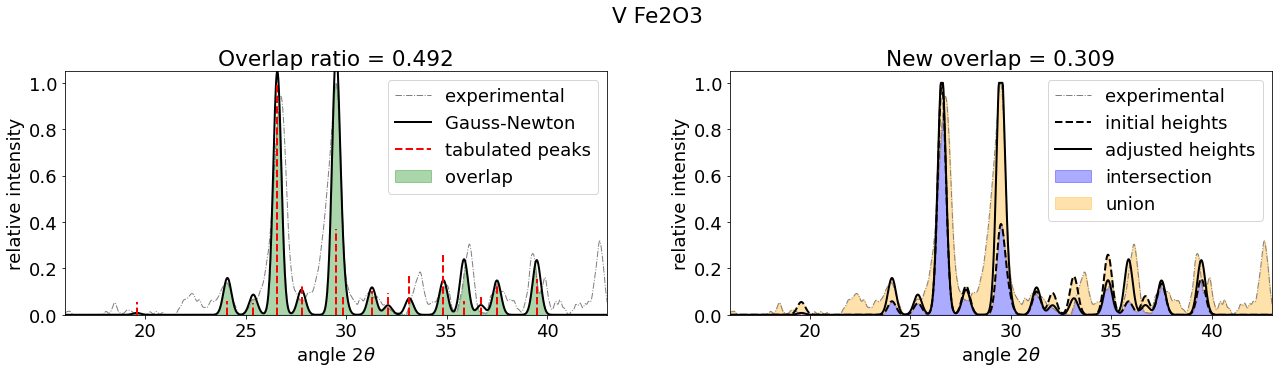

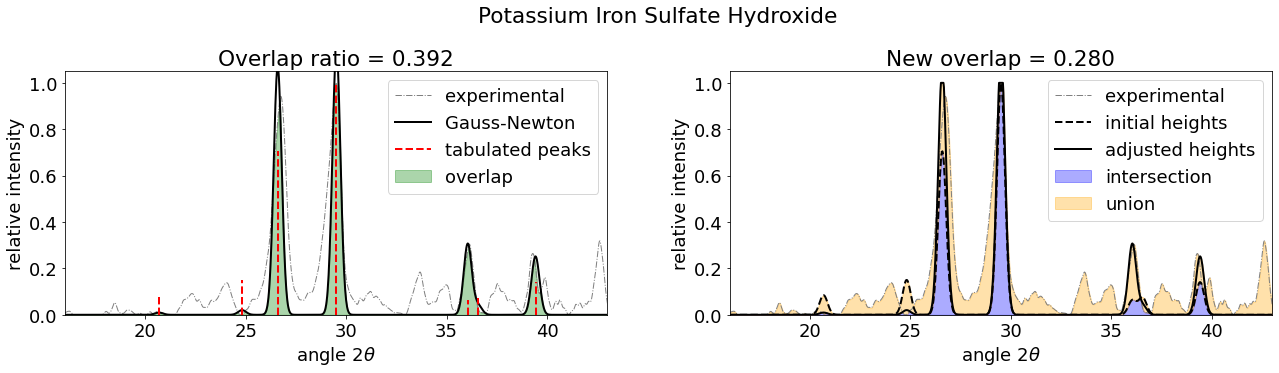

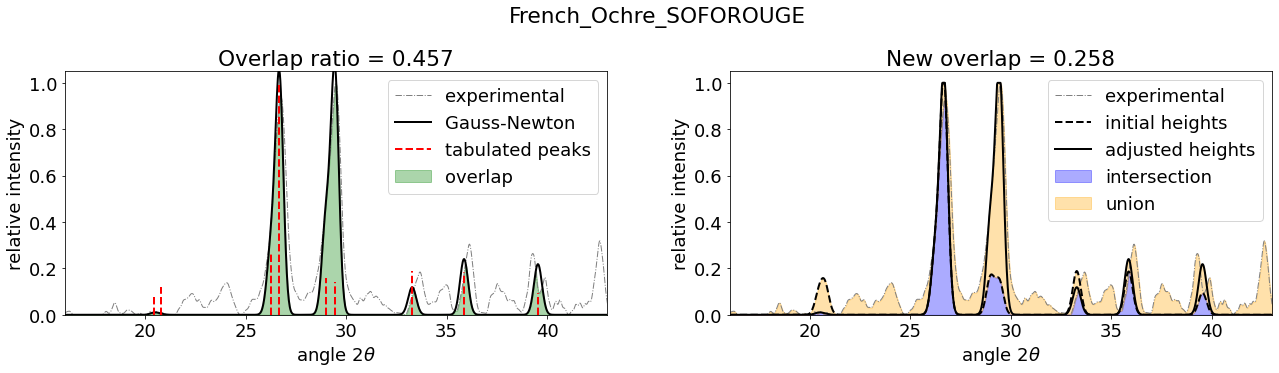

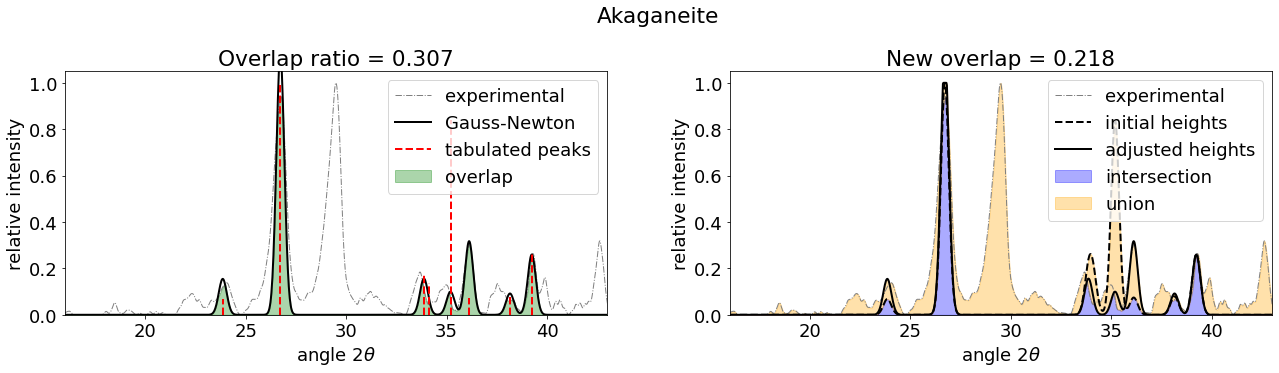

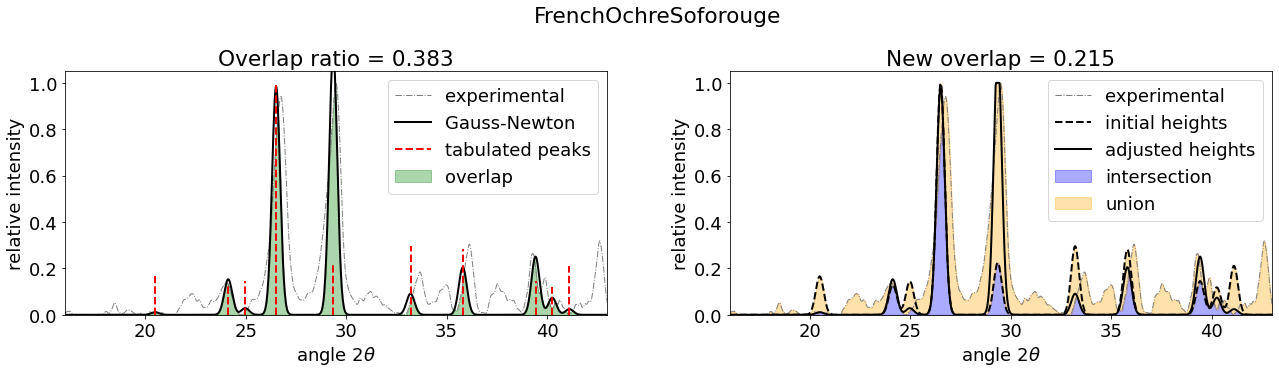

In [18]:
rcParams['font.size'] = 18

### Calibration parameters ###
# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted depending on the value of 'phase_calibration'.
# If phase_calibration is set to a specific phase, the calibration with that phase will be used for the exploration of all the phases.
# If phase_calibration is set to None, each phase is calibrated on experimental XRD pattern.
adjust_calibration = False
#phase_calibration = database['Lazurite'][0]
phase_calibration = None

###

list_phases_check = []
for i in range(df_phases_sel.shape[0]):
    phase_name = df_phases_sel.loc[i, 'Phase']
    phase_sample = df_phases_sel.loc[i, 'Sample']
    phase = database[phase_name][phase_sample]
    list_phases_check.append(phase)

gs = GammaSearch(list_phases_check, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)

for gn in gs:
    
    ### Fit ###
    phase_check = gn.phase


    if adjust_calibration:
        if phase_calibration is None:
            p = phase_check
        else:
            p = phase_calibration
        gn_calibration = GaussNewton(p, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
        gn_calibration.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
        gn.opt = gn_calibration.opt

        arr_to_write = concatenate((gn.theta[:, newaxis], gn.spectrum.counts[:, newaxis]), axis = 1)
        savetxt(f'{path_calibrations}xrd raw calibrated with {clean_phase_name(p.label)}.dat', arr_to_write, '%.3f %d')
        arr_to_write = concatenate((gn.theta[:, newaxis], gn.spectrum.counts_smoothed[:, newaxis]), axis = 1)
        savetxt(f'{path_calibrations}xrd smoothed calibrated with {clean_phase_name(p.label)}.dat', arr_to_write, '%.3f %.3f')

        arr_to_write = concatenate(
            (gn.fce_calibration(peaks_position, *gn.opt)[:, newaxis],
             peaks_intensity[:, newaxis]),
            axis = 1
        )
        savetxt(f'{path_peaks}xrd peaks calibrated with {clean_phase_name(p.label)}.dat', arr_to_write, '%.3f %.3f')

    gn.fit_cycle(gamma = True, steps = 32)

    z0 = clip(gn.z0(), None, 1) # to avoid anomalously high peaks resulting from overlapping tabulated peaks
    z = clip(gn.z(), None, 1)
    intensity_corrected = maximum(gn.intensity, 0)
    z_stack = stack((z0, z, intensity_corrected))
    z_min = z_stack.min(axis = 0)
    z_max = z_stack.max(axis = 0)
    presence = z_min.sum() / z_max.sum()

    ### Plot ###

    fig, axs = subplots(1, 2, figsize = (18, 5))
    fig.tight_layout(w_pad = 4)
    fig.subplots_adjust(top = 0.8)   # To shift the title

    ax = axs[0]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    gn.plot_phase(lw = 2, alpha = 1, label = 'tabulated peaks')
    ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')

    ax = axs[1]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
    ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
    ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'intersection')
    ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'union')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel('relative intensity')
    ax.set_title(f'New overlap = {gn.adjustment_ratio():.3f}')

    fig.suptitle(gn.label)

    savefig(f'{path_figures}{clean_phase_name(gn.label)} - check fit.png', bbox_inches = 'tight', dpi = 300)
    show()
    close(fig)

# Check the fit of an ensemble of phases

### Select phases and check their ensemble
Leave empty list to select all phases.

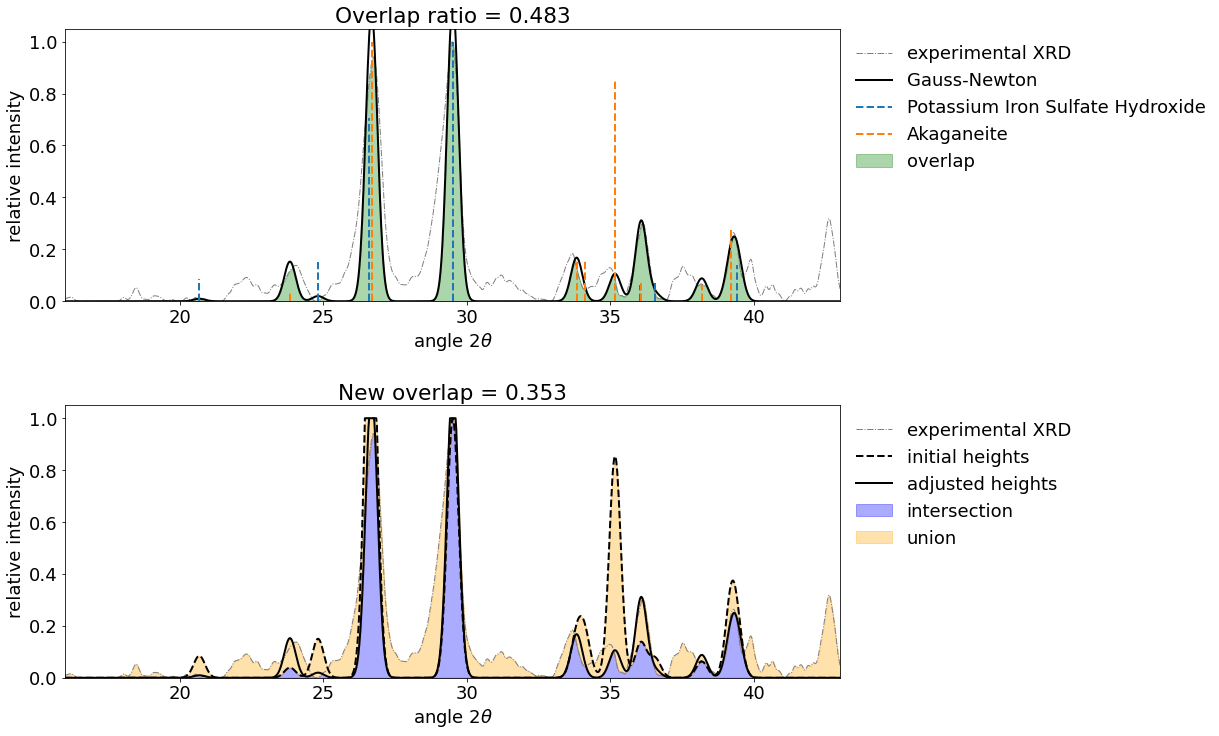

In [21]:
rcParams['font.size'] = 18

### Phase selection ###
phase_check = PhaseList([database['Potassium Iron Sulfate Hydroxide'][0], database['Akaganeite'][0]])

adjust_calibration = False
#phase_calibration = database['Cerussite'][1]
phase_calibration = phase_check

###

gn = GaussNewton(phase_check, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)

if adjust_calibration:
    gn_calibration = GaussNewton(phase_calibration, spectrum_xrd, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
    gn_calibration.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
    gn.opt = gn_calibration.opt
gn.fit_cycle(gamma = True, steps = 32)

z0 = clip(gn.z0(), None, 1) # to avoid anomalously high peaks resulting from overlapping tabulated peaks
z = clip(gn.z(), None, 1)
intensity_corrected = maximum(gn.intensity, 0)
z_stack = stack((z0, z, intensity_corrected))
z_min = z_stack.min(axis = 0)
z_max = z_stack.max(axis = 0)
presence = z_min.sum() / z_max.sum()

### Plot ###

fig, axs = subplots(2, 1, figsize = (12, 10))
fig.tight_layout(h_pad = 4)

ax = axs[0]
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental XRD')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
gn.plot_phase(lw = 2)
ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
ax.legend(frameon = False, bbox_to_anchor = (1, 1), loc = 'upper left')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')

ax = axs[1]
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental XRD')
ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'intersection')
ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'union')
ax.legend(frameon = False, bbox_to_anchor = (1, 1), loc = 'upper left')
ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title(f'New overlap = {gn.adjustment_ratio():.3f}')

savefig(f'{path_figures}{clean_phase_name(gn.label)} - check fit.png', bbox_inches = 'tight', dpi = 300)
show()
close(fig)

# Select phases and save them

### Review list of phases

In [22]:
df_phases_sel.style.format({'Presence': '{:.3f}'})

,Phase,Formula,Sample,Presence
0,V Fe2O3,Fe Mn O,1,0.309
1,Potassium Iron Sulfate Hydroxide,K Fe S O H,0,0.280
2,French_Ochre_SOFOROUGE,Fe2 O3,0,0.258
3,Akaganeite,Cl0.675 Fe4 O8,1,0.218
4,FrenchOchreSoforouge,Fe2 O3,0,0.215


### Select phases to save
Leave empty list to select all phases.

In [23]:
list_names_phase = ['V Fe2O3', 'Potassium Iron Sulfate Hydroxide']
#list_names_phase = []   # leave empty list to select all phases

### Delete file with list of selected phases
Delete the files `phases_selection.dat`.

In [24]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    filename = f'{subfolder_output}phases_selection.dat'
    if exists(filename):
        remove(filename)

### Write file with list of selected phases

This cell writes the list of names of selected phases into the file `phases_selection.dat`. If the file does not exist, the cell creates it.

In [25]:
if len(list_names_phase) > 0:
    df_phases_sel_2 = df_phases_sel[df_phases_sel['Phase'].isin(list_names_phase)]
else:
    df_phases_sel_2 = df_phases_sel

filename = f'{subfolder_output}phases_selection.dat'
df_phases_sel_2.to_csv(filename, header = False, index = False, mode = 'a', float_format = '%.3f')

### Save experimental phases

In [26]:
for gn in gs:
    if ( (len(list_names_phase) == 0) or (gn.label in list_names_phase) ):
        phase_exp = gn.make_phase()
        filename = path_database_exp + clean_phase_name(gn.label) + '.cif'
        print(filename)
        phase_exp.save_cif(filename)

SpotResults/p3verde100s/databaseEXP/V Fe2O3.cif
SpotResults/p3verde100s/databaseEXP/Potassium Iron Sulfate Hydroxide.cif
